In [6]:
import scipy.io
import os
import shutil
try:
    from urllib import urlretrieve # python2
except:
    from urllib.request import urlretrieve # python3

In [8]:
import deephyp.data as data
import numpy as np
import matplotlib.pyplot as plt
import torch as T
import torch
device = T.device("cuda")  # apply to Tensor or Module
import time
from tqdm import tqdm


In [9]:


mat = scipy.io.loadmat( 'PaviaU.mat' )
img = mat[ 'paviaU' ]

# create a hyperspectral dataset object from the numpy array
hypData = data.HypImg( img )

# pre-process data to make the model easier to train
hypData.pre_process( 'minmax' )

AttributeError: 'HypImg' object has no attribute 'shape'

In [37]:


# create data iterator objects for training and validation using the pre-processed data
trainSamples = 200000
valSamples = 100
dataTrain = data.Iterator( dataSamples=hypData.spectraPrep[:trainSamples, :],
                        targets=hypData.spectraPrep[:trainSamples, :], batchSize=4 )
dataVal = data.Iterator( dataSamples=hypData.spectraPrep[trainSamples:trainSamples+valSamples, :],
                        targets=hypData.spectraPrep[trainSamples:trainSamples+valSamples, :] )


In [38]:
# shuffle training data
dataTrain.shuffle()

In [39]:
train_data = torch.tensor(dataTrain.dataSamples.astype(np.float32))
train_data

tensor([[1.7106e-01, 9.8941e-02, 3.9667e-02,  ..., 9.1188e-01, 9.1120e-01,
         9.2923e-01],
        [6.8007e-02, 1.6895e-01, 1.6638e-01,  ..., 8.2164e-01, 8.2293e-01,
         8.1223e-01],
        [2.0957e-01, 1.8101e-01, 9.3401e-02,  ..., 6.9085e-01, 6.9317e-01,
         6.8622e-01],
        ...,
        [4.9285e-07, 5.8650e-02, 1.6659e-01,  ..., 3.1296e-01, 3.1691e-01,
         3.3711e-01],
        [5.1336e-02, 1.8334e-02, 2.6192e-07,  ..., 8.8423e-01, 8.9340e-01,
         9.1095e-01],
        [7.2226e-02, 5.8720e-07, 1.0041e-01,  ..., 2.5426e-01, 2.6130e-01,
         2.5191e-01]])

In [40]:
hypData.numBands
encoderSize=[50,30,10]
encoderSize=[hypData.numBands]+encoderSize
decodersize=encoderSize[::-1]
encoderSize,decodersize

([103, 50, 30, 10], [10, 30, 50, 103])

In [41]:
def force_cudnn_initialization():
    s = 32
    dev = torch.device('cuda')
    torch.nn.functional.conv2d(torch.zeros(s, s, s, s, device=dev), torch.zeros(s, s, s, s, device=dev))

In [42]:
# -----------------------------------------------------------

class Net(T.nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.enn1 = T.nn.Linear(103, 50)  # 64-16-2-16-64
    self.enn2 = T.nn.Linear(50, 30)
    self.enn3 = T.nn.Linear(30,10)
    self.dnn3 = T.nn.Linear(10, 30)  # 64-16-2-16-64
    self.dnn2 = T.nn.Linear(30, 50)
    self.dnn1 = T.nn.Linear(50,103)

  def encoder(self,x):
    z= T.relu(self.enn1(x))
    z= T.relu(self.enn2(z))
    z= T.relu(self.enn3(z))
    return z
  
  def decoder(self,x):
    z= T.relu(self.dnn3(x))
    z= T.relu(self.dnn2(z))
    z= self.dnn1(z)
    return z


  def forward(self, x):
    z=self.encoder(x)
    z= self.decoder(z)
    
    return z
net=Net().to(device)
inpu=torch.rand(1,103).to(device)
outp=net(inpu)
outp.shape


torch.Size([1, 103])

In [ ]:
# -----------------------------------------------------------

force_cudnn_initialization()
# 0. setup
print("\nBegin UCI digits auto-reduce-viz demo job ")
T.manual_seed(1)
np.random.seed(1)

bat_size = 8184
train_ldr = T.utils.data.DataLoader(train_data,
batch_size=bat_size, shuffle=True)
  # 2. create network
print("\nCreating 64-16-2-16-63 autoencoder ")
net = Net().to("cuda:0")

# 3. train model
max_epochs = 1800
ep_log_interval = 10
lrn_rate = 0.0001

loss_func1 = T.nn.MSELoss()
loss_func = T.nn.L1Loss(reduction='sum')
optimizer = T.optim.Adam(net.parameters(), lr=lrn_rate)

print("\nbat_size = %3d " % bat_size)
print("loss = " + str(loss_func))
print("optimizer = Adam")
print("max_epochs = %3d " % max_epochs)
print("lrn_rate = %0.3f " % lrn_rate)

print("\nStarting training")

net = net.train()

for epoch in range(0, max_epochs):
  time.sleep(1)
  loop= tqdm(enumerate(train_ldr), total=len(train_ldr),leave=True)
  epoch_loss = 0  # for one full epoch
  mseloss=0
  for (batch_idx, batch) in loop:
    X = batch.to(device)  # no targets needed

    optimizer.zero_grad()
    oupt = net(X)
    loss_obj = loss_func(oupt, X)  # note: X not Y
    loss_obj1=loss_func1(oupt,X)
    epoch_loss += loss_obj.item()  # accumulate
    mseloss+=loss_obj1.item()
    loss_obj.backward()
    optimizer.step()

    loop.set_description(f"Epoch [{epoch}/{max_epochs}]")
    loop.set_postfix(loss=str(epoch_loss),mseloss=str(mseloss))
"""
  if epoch % ep_log_interval == 0:
    print("epoch = %4d   loss = %0.4f" % (epoch, epoch_loss)) 
print("Done ")"""

# 4. plot digits using reduced form
print("\nCreating graph from encoded data ")
net = net.eval()





In [ ]:

torch.save(net, 'model_l1.pth')

In [ ]:
torch.save(net.state_dict(), 'net_model_l1.pth')

In [43]:
net.load_state_dict(torch.load('net_model_l1.pth'))

<All keys matched successfully>

In [69]:
trex=torch.tensor(hypData.spectraPrep.astype(np.float32))
trex

tensor([[0.1428, 0.1011, 0.0913,  ..., 0.8679, 0.8727, 0.8761],
        [0.1670, 0.1465, 0.1398,  ..., 0.8144, 0.8221, 0.8447],
        [0.2236, 0.2766, 0.1961,  ..., 0.9382, 0.9538, 0.9606],
        ...,
        [0.1139, 0.0292, 0.0460,  ..., 0.8492, 0.8594, 0.8660],
        [0.1068, 0.1744, 0.1333,  ..., 0.8415, 0.8397, 0.8316],
        [0.2278, 0.1603, 0.0520,  ..., 0.8381, 0.8505, 0.8657]])

In [71]:
dataZ=net.encoder(trex.to("cuda"))
dataZ

tensor([[1.4351, 0.4002, 0.0000,  ..., 4.7245, 0.8421, 3.3275],
        [1.4745, 0.4391, 0.0000,  ..., 4.7105, 0.8547, 3.2971],
        [1.4443, 0.3872, 0.0000,  ..., 4.8513, 0.8213, 3.1793],
        ...,
        [1.3826, 0.3651, 0.0000,  ..., 5.0336, 1.4379, 3.4660],
        [1.3982, 0.3283, 0.0000,  ..., 4.9689, 1.3182, 3.3726],
        [1.3897, 0.3045, 0.0000,  ..., 4.9823, 1.2819, 3.4090]],
       device='cuda:0', grad_fn=<ReluBackward0>)

In [73]:
dataY = net.decoder(dataZ)
dataY

tensor([[0.1364, 0.1030, 0.0778,  ..., 0.8624, 0.8634, 0.8718],
        [0.1817, 0.1489, 0.1188,  ..., 0.8117, 0.8105, 0.8166],
        [0.3115, 0.2554, 0.1705,  ..., 0.9162, 0.9196, 0.9284],
        ...,
        [0.0894, 0.0465, 0.0298,  ..., 0.8495, 0.8571, 0.8658],
        [0.2027, 0.1526, 0.1031,  ..., 0.8278, 0.8331, 0.8392],
        [0.1979, 0.1476, 0.0917,  ..., 0.8516, 0.8569, 0.8639]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [79]:
imgZ = np.reshape(dataZ.to("cpu").detach().numpy(), (hypData.numRows, hypData.numCols, -1))

In [80]:
imgY = np.reshape(dataY.to("cpu").detach().numpy(), (hypData.numRows, hypData.numCols, -1))

In [81]:
imgX = np.reshape(hypData.spectraPrep, (hypData.numRows, hypData.numCols, -1))

In [82]:
# visualise latent image using 3 out of the 10 dimensions
colourImg = imgZ.copy()
colourImg = colourImg[ :,:,np.argsort(-np.std(np.std(colourImg, axis=0), axis=0))[:3] ]
colourImg /= np.max(np.max(colourImg, axis=0), axis=0)

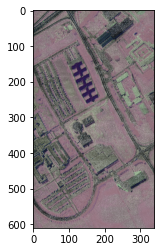

In [84]:
plt.imshow(colourImg)

Text(0.5, 1.0, 'meadow spectra')

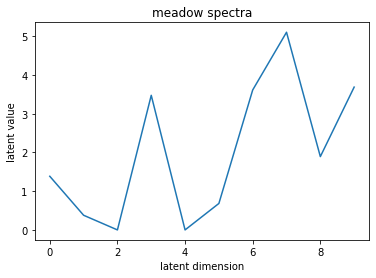

In [85]:
# save plot of latent vector of 'meadow' spectra
fig = plt.figure()
plt.plot(imgZ[576, 210, :])
plt.xlabel('latent dimension')
plt.ylabel('latent value')
plt.title('meadow spectra')

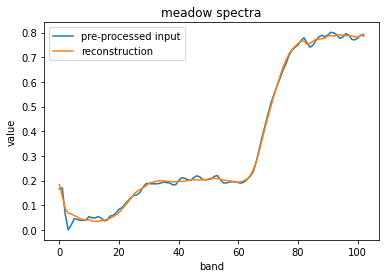

In [86]:
# save plot comparing pre-processed 'meadow' spectra input with decoder reconstruction
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(range(hypData.numBands),imgX[576, 210, :],label='pre-processed input')
ax.plot(range(hypData.numBands),imgY[576, 210, :],label='reconstruction')
plt.xlabel('band')
plt.ylabel('value')
plt.title('meadow spectra')
ax.legend()

In [78]:
dataZ.to("cpu").detach()

tensor([[1.4351, 0.4002, 0.0000,  ..., 4.7245, 0.8421, 3.3275],
        [1.4745, 0.4391, 0.0000,  ..., 4.7105, 0.8547, 3.2971],
        [1.4443, 0.3872, 0.0000,  ..., 4.8513, 0.8213, 3.1793],
        ...,
        [1.3826, 0.3651, 0.0000,  ..., 5.0336, 1.4379, 3.4660],
        [1.3982, 0.3283, 0.0000,  ..., 4.9689, 1.3182, 3.3726],
        [1.3897, 0.3045, 0.0000,  ..., 4.9823, 1.2819, 3.4090]])

In [ ]:
for i in train_data:
    break
out=net(i.to(device))


In [ ]:
i[12]

In [ ]:
loss_func = T.nn.L1Loss(reduction='sum')

In [ ]:
loss_func(out[0].to("cpu"), i[0].to("cpu"))

In [46]:
dataZ = net.load_state_dict(torch.load('net_model_l1.pth'))

In [55]:
print(net)

Net(
  (enn1): Linear(in_features=103, out_features=50, bias=True)
  (enn2): Linear(in_features=50, out_features=30, bias=True)
  (enn3): Linear(in_features=30, out_features=10, bias=True)
  (dnn3): Linear(in_features=10, out_features=30, bias=True)
  (dnn2): Linear(in_features=30, out_features=50, bias=True)
  (dnn1): Linear(in_features=50, out_features=103, bias=True)
)


In [ ]:
hypData.spectraPrep.shape

In [ ]:
imgZ = np.reshape(dataZ, (hypData.numRows, hypData.numCols, -1))


In [ ]:
imgZ.shape